In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon
import numpy as np
import pickle
import gmaps

Census data from US Census Bureau: [U.S. CB](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)

Resource used to understand parsing data with geopandas: [source](https://jcutrer.com/python/learn-geopandas-plotting-usmaps)

In [2]:
states = gpd.read_file('data/cb_2018_us_nation_5m/cb_2018_us_nation_5m.shp')

In [3]:
states

,AFFGEOID,GEOID,NAME,geometry
0,0100000US,US,United States,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ..."


In [4]:
states.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

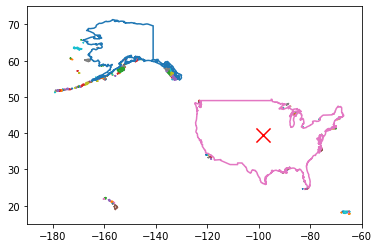

In [5]:
%%capture --no-display
mainland_center = Point(-98.35,39.50)
for i,j in enumerate(states['geometry'][0]):
    x,y = j.exterior.xy
    plt.plot(x,y)
    if mainland_center.within(j):
        mainland = np.array([(yj,xj) for xj,yj in zip(x,y)])
plt.scatter([-98.35], [39.50], c='r', marker='x', s=200)
plt.xlim([-190,-60])
plt.ylim([15,75])
plt.show()

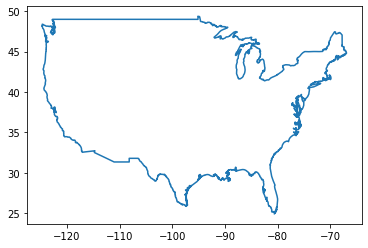

In [6]:
plt.plot(mainland[:,1],mainland[:,0])
plt.show()

In [7]:
pickle.dump(mainland,open("data/pickled_data/mainland.pickle","wb"))

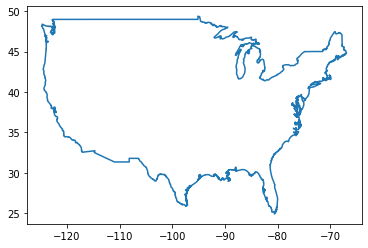

In [8]:
mainland = pickle.load(open("data/pickled_data/mainland.pickle", "rb"))
mainland = Polygon(np.flip(mainland))
x,y = mainland.exterior.xy
plt.plot(x,y)

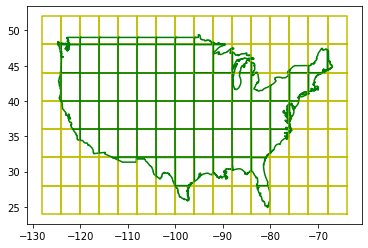

In [9]:
value = mainland.bounds
base = 4

min_x = int(value[0]//base)
min_y = int(value[1]//base)
max_x = int(value[2]//base)
max_y = int(value[3]//base)

for i in range(min_x, max_x + 1):
    for j in range(min_y, max_y + 1):
        y = shapely.geometry.box(i*base, j*base, (i+1)*base, (j+1)*base)
        r = mainland.intersection(y)
        x,y = y.exterior.xy
        plt.plot(x,y,c='y')
        if r.is_empty:
            continue
        elif type(r) == shapely.geometry.multipolygon.MultiPolygon:
            for gems in r.geoms:
                x,y = gems.exterior.xy
                plt.plot(x,y,c='g')
        else:
            x,y = r.exterior.xy
            plt.plot(x,y,c='g')
plt.show()

In [10]:
def partition(mainland, base, mergeFactor):
    '''
    polygon: Unsplit polygon of mainland US
    dim: The dimensions of each grid to split the map into
    mergeFactor: threshold of smallest grid. 
    Any grid smaller will be combined with neighbouring grids
    '''
    value = mainland.bounds
    min_x = int(value[0]//base)
    min_y = int(value[1]//base)
    max_x = int(value[2]//base)
    max_y = int(value[3]//base)
    grid = 0
    res = []
    for i in range(min_x, max_x+1):
        for j in range(min_y, max_y+1):
            y = shapely.geometry.box(i*base, j*base, (i+1)*base, (j+1)*base)
            r = mainland.intersection(y)
            if r.is_empty:
                continue
            if type(r)==shapely.geometry.multipolygon.MultiPolygon:
                for gems in r.geoms:
                    res.append(gems)
                    grid += 1
            else:
                res.append(r)
                grid += 1
    return merge(res, mergeFactor)

def merge(polyList, mergeFactor):
    '''
    polyList: list of polygon grids the map is split into
    mergeFactor: threshold of smallest grid. 
    Any grid smaller will be combined with neighbouring grids
    '''
    def combine(pidx, polyL):
        p = polyL[pidx]
        del polyL[pidx]
        for idx,i in enumerate(polyL):
            u = p.union(i)
            if p.intersects(i) and type(u)!=shapely.geometry.multipolygon.MultiPolygon:
                polyL[idx] = u
                break
        return polyL
    
    mnLimit = max(polyList, key=lambda x:x.area).area * mergeFactor
    mnPoly = min(polyList, key=lambda x:x.area)
    while(mnPoly.area<=mnLimit):
        polyList = combine(polyList.index(mnPoly), polyList)
        mnPoly = min(polyList, key=lambda x:x.area)
        
    result = {}
    for idx,i in enumerate(polyList):
        x,y = i.exterior.xy
        result[idx] = np.array([(y,x) for x,y in zip(x,y)])
    return result

def plotMap(mainlandGrid):
    gPoly = []
    gMarkLoc = []
    gMarkInf = []
    info_box_template = """
    <dl>
    <dd>{}</dd>
    </dl>
    """
    for k,v in mainlandGrid.items():
        gPoly.append(gmaps.Polygon(
                        list(v),
                        stroke_color='red',
                        fill_color='blue'
                        ))
        gMarkLoc.append((v[0][0],v[0][1]))
        gMarkInf.append(info_box_template.format(k))
    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
    fig.add_layer(gmaps.marker_layer(gMarkLoc, info_box_content=gMarkInf))
    return fig

In [17]:
mainlandGrid = partition(mainland, base, mergeFactor=0.2)
len(mainlandGrid)

65

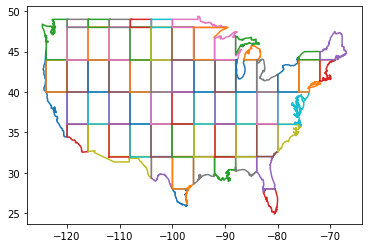

In [15]:
for i in mainlandGrid.values():
    plt.plot(i[:,1],i[:,0])
plt.show()

In [16]:
pickle.dump(mainlandGrid,open("data/pickled_data/mainlandGrid.pickle","wb"))